In [120]:
# Import libraries
import numpy as np
import pandas as pd
import csv
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from collections import Counter
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split

from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from matplotlib import pyplot
import random

from datetime import datetime, timedelta

from pickle import dump, load

from sklearn.pipeline import Pipeline

In [121]:
# Load training dataset
filename = 'data\TRAIN_CLAIM_FL_ALL_GROUPED.csv'
dataset = pd.read_csv(filename, low_memory=False)
print(dataset.shape)

(13230, 244)


In [122]:
# Extract the target variable and checking the class distribution
target = dataset['target']
print(Counter(target))

Counter({0: 7427, 1: 5803})


In [123]:
######################################################################################################
#Data exploratory
#####################################################################################################

# Filter Eligibles variables for the model (we did not drop provider_id and maxdos because they are goint to be used to split data)
collist = dataset.columns.tolist()
columnsToDrop = np.array(['id', ~~])
for c in columnsToDrop:
    collist.remove(c)
datasetFiltered = dataset[collist]

# Dataset shape
print(datasetFiltered.shape)

# Find columns with any missing values
columnsDF = pd.DataFrame(datasetFiltered.isnull().any(), columns = np.array(['hasMissing']))
print(columnsDF.query('hasMissing == True'))

# Find rows with any missing values
null_data = datasetFiltered[datasetFiltered.isnull().any(axis=1)]
print(null_data.shape[0])

# Ignore those rows with missing data
datasetFiltered = datasetFiltered.dropna()

# Extract the target variable and checking the class distribution
target = datasetFiltered['target']
datasetFiltered = datasetFiltered.drop('target', 1)
print(Counter(target))

# Extract the provider_id and DOS variables for future split
provider_id = datasetFiltered['provider_id']
datasetFiltered = datasetFiltered.drop('provider_id', 1)
maxdos = datasetFiltered['maxdos']
datasetFiltered = datasetFiltered.drop('maxdos', 1)

# Descriptive stats
pd.DataFrame(datasetFiltered.describe()).to_csv('descriptive_stats.csv')

# Skew for each attribute 
pd.DataFrame(datasetFiltered.skew()).to_csv('skew.csv')

# Correlations
pd.DataFrame(datasetFiltered.corr(method='pearson')).to_csv('correlations.csv')

# Are there constant variables?
constant = datasetFiltered.loc[:, datasetFiltered.apply(pd.Series.nunique) == 1]
print(constant.columns)

# Checking some variable importance
selector = SelectKBest(score_func=f_classif, k=10)
fit = selector.fit(datasetFiltered, target)

varImp = dict()
for variable, score, topX in zip(datasetFiltered.columns, fit.scores_, selector.get_support()):
    varImp[variable] = score
pd.DataFrame.from_dict(varImp, orient='index').to_csv('varImp.csv')



(13230, 224)
                             hasMissing
qtdclaimsprovider                  True
qtdclaimlinesprovider              True
qtdmemberprovider                  True
avgticketperclaimprovider          True
avgticketpermemberprovider         True
avgclaimspermemberprovider         True
avgclaimlineperclaimprovider       True
qtdclaimsmember                    True
qtdclaimlinesmember                True
qtdprovidermember                  True
avgticketperclaimmember            True
avgticketperprovidermember         True
avgclaimsperprovidermember         True
avgclaimlineperclaimmember         True
provider_age_time_of_service       True
amount_paid                        True
133
Counter({0: 7333, 1: 5764})
Index(['source', '8080'], dtype='object')


C:\Users\wmoura\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [107 215] are constant.
  UserWarning)


In [124]:
######################################################################################################
#Feature selecion
#####################################################################################################

# Drop some correlated variables (manual analysis - greater than 0.6)
collist = datasetFiltered.columns.tolist()
columnsHighCorr_GT06 = np.array(['has_radiography','4355','is_member_under_10','9230','amount_claim','0230','amount_cost',
                                 '2391','2933','PREVENTIVE','has_bitewing','2392','1120','7140','8220', '9310',
                                 'has_stainless_steel_crowns','2930','ADJ','0272','has_pulpotomies','3220','1351',
                                 'has_molar','RESTORATIVE', '3330', 'avgticketpermemberprovider', 'avgticketperclaimmember', 
                                 'avgticketperprovidermember', 'qtdmemberprovider', 'qtdclaimsmember', 'qtdclaimsprovider', 
                                 'avgclaimsperprovidermember',
                                 'avg_total_comb1', 'max_total_comb1', 'avg_zscore_comb1', 'min_zscore_comb1', 
                                 'max_zscore_comb1', 'avg_total_comb2', 'avg_zscore_comb2', 'max_zscore_comb2', 
                                 'avg_zscore_comb3', 'max_zscore_comb3', 'avg_zscore_comb4', 'max_zscore_comb4',
                                 'sum_total_comb1351', 'avg_total_comb1351', 'min_total_comb1351', 'max_total_comb1351', 
                                 'sum_total_comb0272','avg_total_comb0272', 'min_total_comb0272', 'max_total_comb0272',
                                 'sum_total_comb2', 'max_total_comb2', 'sum_total_comb3', 'avg_total_comb3', 
                                 'max_total_comb3','sum_total_comb4', 'avg_total_comb4', 'max_total_comb4',
                                 'sum_total_comb3220', 'avg_total_comb3220', 'max_total_comb3220', 'indicator_6_eligible',
                                 'indicator_8_eligible', 'indicator_9_eligible', 'indicator_13_eligible', 
                                 'indicator_14_eligible', 'indicator_16_eligible', 'indicator_9_result', 
                                 'indicator_17_result', 'min_total_comb2', 'min_zscore_comb2', 'min_total_comb3',
                                 'min_total_comb4', 'min_zscore_comb3', 'min_ratio_1351', 'max_ratio_1351', 'min_ratio_3220',
                                 'max_ratio_3220', 'min_ratio_0272', 'max_ratio_0272', 'indicator_7_eligible', 
                                 'indicator_10_eligible', 'avg_total_combrest', 'min_total_combrest', 'max_total_combrest',
                                 'min_ratio_rest', 'max_ratio_rest', 'sum_total_comb1', 'avgclaimlineperclaimmember',
                                 'indicator_17_eligible', 'FQHC', '5120', '0260', 'source', '8080'
                                
                                ])

for c in columnsHighCorr_GT06:
    if c in collist:
        collist.remove(c)
datasetWithoutCorr = datasetFiltered[collist]

# Drop some variables with low importance (p-value < 0.05)
filtered_dict = {k:v for (k,v) in varImp.items() if v < 0.05}
columnsLowImp = list(filtered_dict.keys())

collist = datasetWithoutCorr.columns.tolist()
for c in columnsLowImp:
    if c in collist:
        collist.remove(c)
datasetHighImp = datasetWithoutCorr[collist]

# Dataset dim
print(datasetHighImp.shape)

# New correlations
pd.DataFrame(datasetHighImp.corr(method='pearson')).to_csv('correlations.csv')

(13097, 109)


In [126]:
######################################################################################################
# Some "global" parameters
#####################################################################################################
seed = 7
scoring = 'recall'
test_size = 0.25
n_splits = 10
kfold = KFold(n_splits=n_splits, random_state=seed) 

In [127]:
######################################################################################################
# Random split
#####################################################################################################

# Prepare the dataset
X = datasetHighImp.values
Y = target

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

ADA: 0.669685 (0.024962)
GB: 0.732109 (0.016884)
RF: 0.760253 (0.022474)
CART: 0.803690 (0.018850)


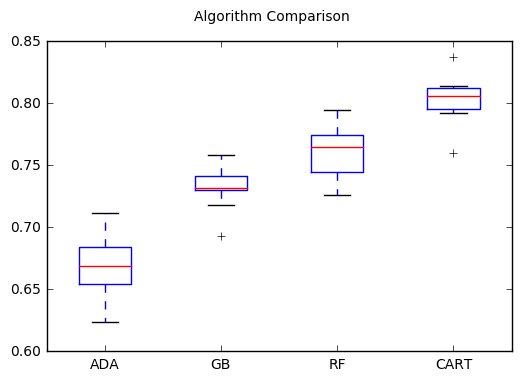

In [94]:
# prepare models 
models = [] 
models.append(('ADA', AdaBoostClassifier())) 
models.append(('GB', GradientBoostingClassifier())) 
models.append(('RF', RandomForestClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
#models.append(('SVM', SVC()))

# evaluate each model in turn 
results = [] 
names = [] 

for name, model in models: 
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) 
    print(msg)

# Compare models
fig = pyplot.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
pyplot.boxplot(results) 
ax.set_xticklabels(names) 
pyplot.show()

In [129]:
# Create the baseline model (the best one from model comparison task)
baseline = DecisionTreeClassifier(random_state = seed)
baseline.fit(X_train, Y_train)

# Feature importance
featureName = pd.DataFrame(datasetHighImp.columns, columns=['Feature'])
featureImp = pd.DataFrame(baseline.feature_importances_, columns=['Imp'])
pd.concat([featureName, featureImp], axis=1).to_csv('varImpTree.csv')

# Test the best model
predictions = baseline.predict(X_test)
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

TypeError: append() takes exactly one argument (2 given)

In [12]:
# Save the model to disk 
filename = 'binary_class_model.sav' 
dump(baseline, open(filename, 'wb'))

# load the model from disk 
#loaded_model = load(open(filename, 'rb')) 
#result = loaded_model.score(X_test, Y_test) 
#print(result)# Create the final model